# Map statistics of objects in one channel in relation to overlapping objects in another channel

This notebook shows how to measure features of segmentated objects arising from multichannel images. It shows how to do that in the following ways:

1. **measure_labels**: Get features from on one segmented image (it needs one label image);
    
2. **measure_labels_with_intensity**: Get features (including intensity) from one segmented image and one intensity image (it needs one label image and one intensity image);
    
3. **measure_labels_in_labels**: Get features from two segmented images, relating objects from one image to another image (it needs two label images, one being a reference);
    
4. **measure_labels_in_labels_with_intensity**: Get features (including intensity features) rom two segmented images and two intensity images (it needs two label images and two intensity images);

5. **link_two_label_images**: Get which objects from one segmented image "belong" to another.

We start by loading a couple of simple example images: two label images and two intensity images.

In [1]:
from skimage import io
import numpy as np
import pandas as pd
import napari
from napari.utils import nbscreenshot
from napari_skimage_regionprops import measure_labels, measure_labels_with_intensity, measure_labels_in_labels, measure_labels_in_labels_with_intensity, link_two_label_images, make_summary_table

In [2]:
image_channel1 = io.imread('../data/actin.tif')
image_channel2 = io.imread('../data/dna.tif')
cell_labels = io.imread('../data/cell_labels.tif')
dna_labels = io.imread('../data/dna_labels.tif')

In [3]:
viewer = napari.Viewer()

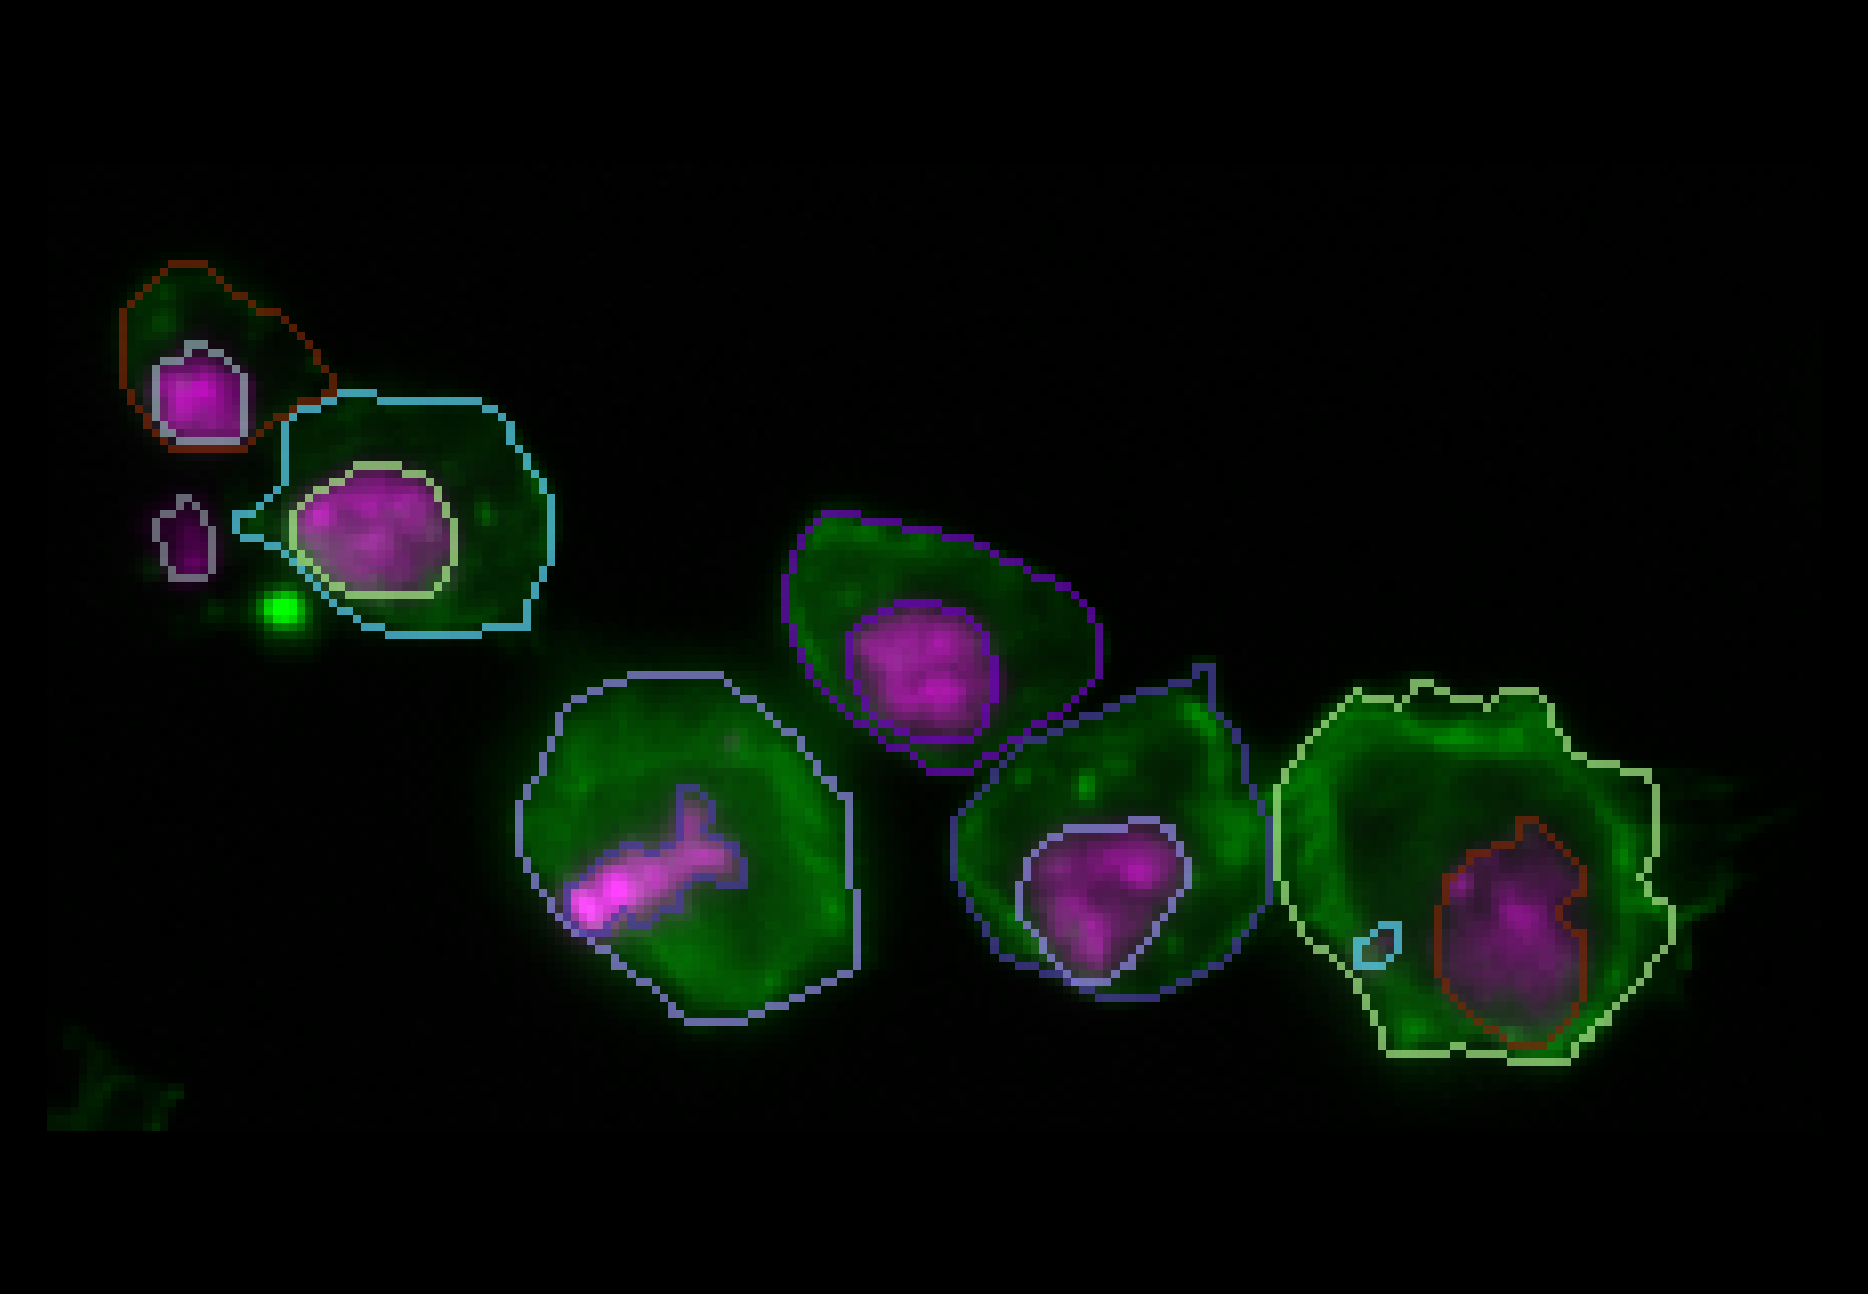

In [4]:
viewer.add_image(image_channel1, name = 'dna', colormap='green')
viewer.add_image(image_channel2, name = 'dna', colormap='magenta', blending='additive')
cell_labels_layer = viewer.add_labels(cell_labels)
cell_labels_layer.contour = 1
dna_labels_layer = viewer.add_labels(dna_labels)
dna_labels_layer.contour = 1
# viewer.grid.enabled = True
nbscreenshot(viewer, canvas_only=True)

## 1. Measure Lables

To measure cell size and shape features from one label image, we can use the function `measure_labels` providing the labeled image as an argument. By doing that, we get a table with size and shape properties.

In [5]:
measurements = measure_labels(reference_labels=cell_labels)
measurements

,label,area,bbox_area,convex_area,equivalent_diameter
0,1,442,648,461,23.722813
1,2,910,1240,972,34.038919
2,3,1407,1892,1452,42.325501
3,4,911,1320,941,34.057616
4,5,1185,1680,1231,38.843131
5,6,1803,2400,1919,47.912951


## Measure cell intensity features

In [6]:
measurements_with_intensity = measure_labels_with_intensity(reference_labels=cell_labels, intensity_image=image_channel1)
measurements_with_intensity

,label,area,bbox_area,convex_area,equivalent_diameter,max_intensity,mean_intensity,min_intensity,standard_deviation_intensity
0,1,442,648,461,23.722813,64.0,23.988688,9.0,10.084142
1,2,910,1240,972,34.038919,96.0,42.542857,16.0,14.954136
2,3,1407,1892,1452,42.325501,128.0,72.480455,24.0,16.704404
3,4,911,1320,941,34.057616,105.0,45.803513,14.0,16.341103
4,5,1185,1680,1231,38.843131,135.0,51.278481,20.0,19.006819
5,6,1803,2400,1919,47.912951,136.0,56.301165,16.0,24.383326


## Link each cell to objects in another channel

In [7]:
labels_relationship = link_two_label_images(reference_labels=cell_labels, labels_to_measure=dna_labels)
labels_relationship

,label_reference,label
0,0,8
1,1,7
2,2,6
3,3,5
4,4,4
5,5,3
6,6,1
7,6,2


## Link each cell to objects in another channel along with their size and shape features

In [12]:
measurements_linked = measure_labels_in_labels(reference_labels=cell_labels,
                                                labels_to_measure=dna_labels,
                                                suffixes=['_cells', '_dna'])
measurements_linked

c:\users\mazo260d\documents\github\napari-skimage-regionprops\napari_skimage_regionprops\_regionprops.py:777: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  output_table = pd.merge(output_table,


,label_cells,area_cells,bbox_area_cells,convex_area_cells,equivalent_diameter_cells,label_dna,area_dna,bbox_area_dna,convex_area_dna,equivalent_diameter_dna
0,1,442.0,648.0,461.0,23.722813,7,130,156,135,12.865502
1,2,910.0,1240.0,972.0,34.038919,6,283,357,293,18.982276
2,3,1407.0,1892.0,1452.0,42.325501,5,210,437,271,16.351768
3,4,911.0,1320.0,941.0,34.057616,4,275,342,284,18.712052
4,5,1185.0,1680.0,1231.0,38.843131,3,329,462,345,20.466944
5,6,1803.0,2400.0,1919.0,47.912951,1,413,551,437,22.931374
6,6,1803.0,2400.0,1919.0,47.912951,2,28,36,29,5.970821
7,0,NaN,NaN,NaN,NaN,8,66,88,70,9.166996


## Get individual cell summary statistics for each feature

In [15]:
measurements_linked_summary = make_summary_table(measurements_linked,
                                                suffixes=['_cells', '_dna'],
                                                statistics_list=['count', 'mean'])
measurements_linked_summary

,label_cells,counts_dna,area_dna mean,bbox_area_dna mean,convex_area_dna mean,equivalent_diameter_dna mean
0,0,1,66.0,88.0,70.0,9.166996
1,1,1,130.0,156.0,135.0,12.865502
2,2,1,283.0,357.0,293.0,18.982276
3,3,1,210.0,437.0,271.0,16.351768
4,4,1,275.0,342.0,284.0,18.712052
5,5,1,329.0,462.0,345.0,20.466944
6,6,2,220.5,293.5,233.0,14.451098


## Link each cell to objects in another channel along with their intensity features

In [10]:
measurements_with_intensity_linked = measure_labels_in_labels_with_intensity(reference_labels=cell_labels,
                                                                intensity_image_of_reference=image_channel1,
                                                                labels_to_measure=dna_labels,
                                                                intensity_image_of_labels_to_measure=image_channel2,
                                                                suffixes=['_cells', '_dna'])
measurements_with_intensity_linked

z:\programming\github\napari-skimage-regionprops\napari_skimage_regionprops\_regionprops.py:682: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  output_table = pd.merge(output_table,


,label_cells,area_cells,bbox_area_cells,convex_area_cells,equivalent_diameter_cells,max_intensity_cells,mean_intensity_cells,min_intensity_cells,standard_deviation_intensity_cells,label_dna,area_dna,bbox_area_dna,convex_area_dna,equivalent_diameter_dna,max_intensity_dna,mean_intensity_dna,min_intensity_dna,standard_deviation_intensity_dna
0,1,442.0,648.0,461.0,23.722813,64.0,23.988688,9.0,10.084142,7,130,156,135,12.865502,183.0,104.346154,19.0,40.762674
1,2,910.0,1240.0,972.0,34.038919,96.0,42.542857,16.0,14.954136,6,283,357,293,18.982276,182.0,99.568905,28.0,34.877849
2,3,1407.0,1892.0,1452.0,42.325501,128.0,72.480455,24.0,16.704404,5,210,437,271,16.351768,247.0,127.585714,24.0,55.615558
3,4,911.0,1320.0,941.0,34.057616,105.0,45.803513,14.0,16.341103,4,275,342,284,18.712052,173.0,96.658182,23.0,37.846574
4,5,1185.0,1680.0,1231.0,38.843131,135.0,51.278481,20.0,19.006819,3,329,462,345,20.466944,161.0,79.708207,10.0,32.925170
5,6,1803.0,2400.0,1919.0,47.912951,136.0,56.301165,16.0,24.383326,1,413,551,437,22.931374,132.0,58.987893,14.0,24.761279
6,6,1803.0,2400.0,1919.0,47.912951,136.0,56.301165,16.0,24.383326,2,28,36,29,5.970821,56.0,35.607143,13.0,11.564537
7,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,66,88,70,9.166996,94.0,46.030303,22.0,17.076450
